In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [45]:
##############
## Data Loading + Prepping Stage
##############
#df = pd.read_csv('/home/mheichler/venv/Datasets/UNSW_NB15_training-set.csv')
df = pd.read_csv('C:/Users/Michael/anac_enviro/Datasets/111554_267091_compressed_UNSW_NB15_training-set.csv.zip')
df.attack_cat = df.attack_cat.apply(lambda x: 'Normal' if x == 'Normal' else 'Attack')

class2idx = {
    'Normal':0,
    'Attack':1,      
}

idx2class = {v: k for k, v in class2idx.items()}

df['attack_cat'].replace(class2idx, inplace=True)
df = df.drop('label', axis = 1)
category_col = ['proto', 'service', 'state', 'is_ftp_login', 'is_sm_ips_ports']
numerical_col = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst']
num_feature = df.drop(category_col,axis = 1)

X = num_feature.iloc[:, 0:-1]
y = num_feature.iloc[:, -1]

In [46]:
X.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst
0,1,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,...,2,2,1,1,1,2,0,0,1,2
1,2,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,...,2,2,1,1,1,2,0,0,1,2
2,3,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,...,3,2,1,1,1,3,0,0,1,3
3,4,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,...,3,2,2,2,1,3,0,0,2,3
4,5,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,...,3,2,2,2,1,3,0,0,2,3


In [47]:
##############
## Unsupervised: Only training with normal data
##############
X_train = num_feature[num_feature.attack_cat==0].sample(10000)
y_train = X_train.iloc[:, -1]
X_train = X_train.drop('attack_cat', axis = 1)

##############
## Split into train+val and test
##############

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [48]:
##############
## Min/Max Scaling
##############

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

Text(0.5, 1.0, 'Class Distribution in Test Set')

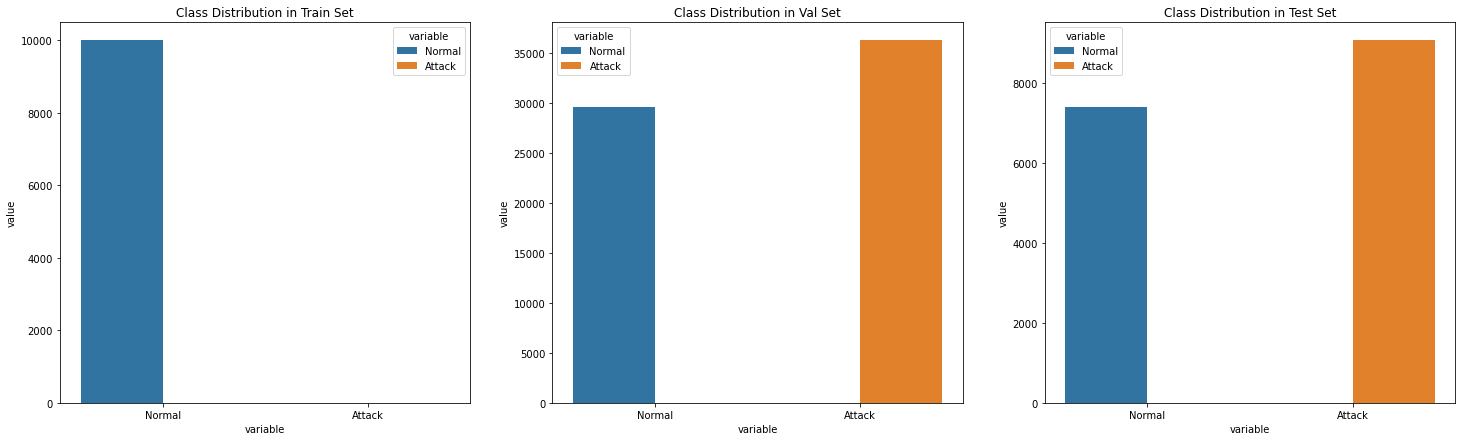

In [49]:
def get_class_distribution(obj):
    count_dict = {
        'Normal':0,
        'Attack':1,        
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Normal'] += 1
        elif i == 1: 
            count_dict['Attack'] += 1        
        else:
            print("Check classes.")
            
    return count_dict

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [50]:
X_train = np.pad(X_train, ((0, 0), (0, 64 - len(X_train[0]))), 'constant').reshape(-1, 1, 8, 8)
X_val = np.pad(X_val, ((0, 0), (0, 64 - len(X_val[0]))), 'constant').reshape(-1, 1, 8, 8)
X_test = np.pad(X_test, ((0, 0), (0, 64 - len(X_test[0]))), 'constant').reshape(-1, 1, 8, 8)

In [51]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], index
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [52]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 1
nu = 0.1

test_auc = None
test_scores = None

In [53]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)

val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [54]:
class CNN(nn.Module):
    def __init__(self, num_feature, num_class):
        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(True),
            nn.Conv2d(6, 16, 3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(144, 512),
            nn.Linear(512, 256),
            nn.Linear(256, num_class)
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, dataset):
        dist = torch.sum((y_test_pred - c)**2, dim=1)
        outputs = self(dataset)
        _, predicted = torch.max(outputs, 1)
        return predicted

In [55]:
model = CNN(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

print(model)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=144, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [56]:
def init_center_c(dataloader,net,eps=0.1):
    n_samples = 0
    c = torch.zeros(NUM_CLASSES, device='cuda')
    
    model.eval()
    with torch.no_grad():
        for data, _, _ in train_loader:
            inputs = data.to(device)
            outputs = model(inputs)
            n_samples += outputs.shape[0]
            c += torch.sum(outputs, dim=0)    
    
    c /= n_samples
    print(c)
    c[(abs(c) < eps) & (c < 0)] = -eps
    c[(abs(c) < eps) & (c > 0)] = eps

    return c

In [57]:
def get_radius(dist, nu):
    return np.quantile(np.sqrt(dist.clone().data.cpu()), 1 - nu)

R = 0
R = torch.tensor(R, device='cuda')

In [58]:
c = init_center_c(train_loader, model)

tensor([0.0142], device='cuda:0')


In [59]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [60]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    n_batches = 0
    n_batches_val = 0
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    
    for data in train_loader:
        inputs, _, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()        
        y_train_pred = model(inputs)       
        dist = torch.sum((y_train_pred - c) ** 2, dim=1)       
        
        train_loss = torch.mean(dist)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        n_batches += 1
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for data in val_loader:
            inputs, label, _ = data
            inputs = inputs.to(device) 
            y_val_pred = model(inputs) 
            
            dist_val = torch.sum((y_val_pred - c) ** 2, dim=1)             
            val_loss = torch.mean(dist_val)    
        
            val_epoch_loss += val_loss.item()
        
            n_batches += 1
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader)) 
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/n_batches:.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 001: | Train Loss: 0.00066 | Val Loss: 0.00948
Epoch 002: | Train Loss: 0.00022 | Val Loss: 0.00366
Epoch 003: | Train Loss: 0.00014 | Val Loss: 0.00212
Epoch 004: | Train Loss: 0.00011 | Val Loss: 0.00156
Epoch 005: | Train Loss: 0.00009 | Val Loss: 0.00130
Epoch 006: | Train Loss: 0.00008 | Val Loss: 0.00114
Epoch 007: | Train Loss: 0.00007 | Val Loss: 0.00104
Epoch 008: | Train Loss: 0.00007 | Val Loss: 0.00097
Epoch 009: | Train Loss: 0.00006 | Val Loss: 0.00094
Epoch 010: | Train Loss: 0.00006 | Val Loss: 0.00092
Epoch 011: | Train Loss: 0.00005 | Val Loss: 0.00091
Epoch 012: | Train Loss: 0.00005 | Val Loss: 0.00092
Epoch 013: | Train Loss: 0.00005 | Val Loss: 0.00092
Epoch 014: | Train Loss: 0.00005 | Val Loss: 0.00094
Epoch 015: | Train Loss: 0.00004 | Val Loss: 0.00095
Epoch 016: | Train Loss: 0.00004 | Val Loss: 0.00096
Epoch 017: | Train Loss: 0.00004 | Val Loss: 0.00097
Epoch 018: | Train Loss: 0.00004 | Val Loss: 0.00098
Epoch 019: | Train Loss: 0.00004 | Val Loss: 0

In [61]:
test_auc = None
idx_label_score = []
with torch.no_grad():
    model.eval()
    for data in test_loader:
        inputs, labels, idx = data
        inputs = inputs.to(device)
        y_test_pred = model(inputs)
        dist = torch.sum((y_test_pred - c)**2, dim=1)
        scores_fin = dist
                
        idx_label_score += list(zip(idx.cpu().data.numpy().tolist(),
                                    labels.cpu().data.numpy().tolist(),
                                    scores_fin.cpu().data.numpy().tolist()))

In [62]:
test_scores = idx_label_score

In [63]:
_, labels, scores = zip(*idx_label_score)
labels = np.array(labels)
scores = np.array(scores)

In [64]:
(unique, counts) = np.unique(labels, return_counts=True)
freq_test = np.asarray((unique, counts)).T
print(freq_test)

[[   0 7400]
 [   1 9067]]


In [65]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(labels, scores)
print('Test set AUC: {:.2f}%'.format(100. * test_auc))

Test set AUC: 71.06%


0.7106485055696482


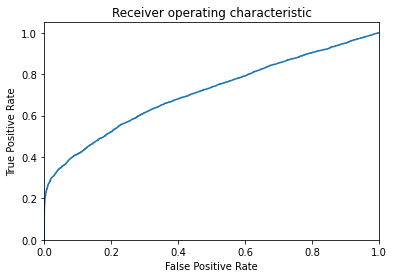

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(labels, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(labels, scores))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [23]:
torch.save(model.state_dict(), "unsw_nb15")
model.load("unsw_nb15")

In [41]:
#df_test = pd.read_csv('/home/mheichler/venv/Datasets/UNSW_NB15_testing-set.csv')
#df_test = pd.read_csv('C:/Users/Michael/anac_enviro/Datasets/111554_267091_compressed_UNSW_NB15_testing-set.csv')
df_test = pd.read_csv('C:/Users/Michael/anac_enviro/Datasets/UNSW_NB15_testing-set.csv')

df_test = df_test.drop('attack_cat', axis = 1)
pred_label = df_test.label
pred_label = pred_label.to_numpy()
df_test = df_test.drop('label', axis = 1)
num_feature_test = df_test.drop(category_col,axis = 1)
numeric_dataset = scaler.fit_transform(num_feature_test)
numeric_dataset = np.array(numeric_dataset)
numeric_dataset = np.pad(numeric_dataset, ((0, 0), (0, 64 - len(numeric_dataset[0]))), 'constant').reshape(-1, 1, 8, 8)
numeeric_tensor = ClassifierDataset(torch.from_numpy(numeric_dataset).float(), torch.from_numpy(pred_label).long())
#numeric_tensor = torch.from_numpy(numeric_dataset).float().to(device)
pred_loader = DataLoader(dataset=numeric_tensor, batch_size=BATCH_SIZE)
model.eval()
for data in pred_loader:
        inputs = data
        inputs = inputs.to(device)
        y_test_pred = model(inputs)
        dist = torch.sum((y_test_pred - c)**2, dim=1)
        score_pred = dist
        
        pred_label = score_pred.cpu().data.numpy().tolist()

In [42]:
pred_label

[4.144192280364223e-05,
 4.7452991566387936e-05,
 3.3510971206851536e-06,
 1.3102352340865764e-06,
 1.5068977177179477e-08,
 1.6209782188525423e-05,
 1.8150169125874527e-05,
 2.6628486011759378e-05,
 3.835478128166869e-05,
 4.5093023004483257e-07,
 3.5310299608681817e-06,
 0.00030858436366543174,
 0.0003241533995606005,
 4.239558256813325e-05,
 3.879559358210827e-07,
 4.9176534957950935e-05,
 1.709574206643083e-07,
 0.0003085791249759495,
 2.4987546112242853e-06,
 4.403117054607719e-05,
 2.6932650598610053e-06,
 1.7105601557432237e-07,
 4.514106421993347e-07,
 3.3063749924622243e-06,
 5.302985664457083e-05,
 4.138827534916345e-06,
 4.139251814194722e-06,
 4.516109015639813e-07]

In [ ]:
(unique, counts) = np.unique(pred_scores, return_counts=True)
freq_pred = np.asarray((unique, counts)).T
print(freq_pred)

In [29]:
pred_scores

array(<zip object at 0x000002248498C100>, dtype=object)

In [ ]:
pre_numpy = predicted.detach().numpy()

In [ ]:
(unique, counts) = np.unique(pre_numpy, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [ ]:
print(frequencies)

In [ ]:
#df_test2 = pd.read_csv('/home/mheichler/venv/Datasets/UNSW_NB15_testing-set.csv')
df_test2 = pd.read_csv('C:/Users/Michael/anac_enviro/Datasets/111554_267091_compressed_UNSW_NB15_testing-set.csv.zip')
df_test2['attack_cat'].replace(class2idx, inplace=True)
result = pd.DataFrame(data={'Id': df_test2['id'], 'attack_cat': df_test2['attack_cat'], 'predict': predicted})
result.to_csv(path_or_buf='submittion.csv', index = False, header = True)

In [ ]:
sns.catplot(y="attack_cat", hue="predict", kind="count",
            palette="pastel", edgecolor=".6",
            data=result);

In [ ]:
result.predict.unique()

In [ ]:
result.attack_cat.unique()

In [ ]:
result.Id.count()